This notebook tries to extend the results from the adversarial spheres paper: https://arxiv.org/pdf/1801.02774.pdf

In particular, instead of generating from spheres, we generate from Gaussians
(with the hope that the high dimensionality makes them effectively spheres).

Additionally, study the influence of the scale of the samples.
We study when the samples have norm $O(1)$ (paper) and $O(\sqrt{D})$ (real life).

### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent

tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Data generation utils

In [2]:
def generate_normal_data(dim, s1, s2, num_samples):
    assert num_samples % 2 == 0
    
    xs = np.concatenate([
        np.random.normal(scale=s1, size=(num_samples // 2, dim)),
        np.random.normal(scale=s2, size=(num_samples // 2, dim))
    ])
    
    ys = np.concatenate([
        np.zeros(shape=num_samples // 2, dtype=np.int64),
        np.ones(shape=num_samples // 2, dtype=np.int64)
    ])
    
    perm = np.random.permutation(num_samples)
    xs = xs[perm]
    ys = ys[perm]
    
    return xs, ys

generate_normal_data(dim=2, s1=0.3, s2=0.7, num_samples=4)

(array([[-0.07919211, -0.45616192],
        [ 0.17957665, -0.10098333],
        [ 1.62449755, -0.13390125],
        [-0.02627816, -0.37209498]]),
 array([0, 0, 1, 1], dtype=int64))

### Experiment setup

In [3]:
def run_experiment(
    dim,
    s1,
    s2,
    model_layers,
    train_epochs,
    attack_norm,
    attack_eps,
    attack_eps_step,
    attack_iters,
    train_batch_size=64,
    attack_batch_size=256,
    num_train=5 * 10 ** 4,
    num_test=10 ** 4,
    seed=42
):
    """
    Default values for num_train and num_test are size of CIFAR10 dataset.
    
    Keras code derived from https://keras.io/examples/vision/mnist_convnet/.
    
    ART code derived from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    and https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    x_train, y_train = generate_normal_data(
        dim=dim, s1=s1, s2=s2,
        num_samples=num_train,
    )

    x_test, y_test = generate_normal_data(
        dim=dim, s1=s1, s2=s2,
        num_samples=num_test,
    )
    
    model = keras.Sequential(
        [keras.Input(shape=x_train[0].shape)]
        + model_layers
    )
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer="adam",
        metrics=["accuracy"]
    )
    model.fit(
        x_train,
        y_train,
        batch_size=train_batch_size,
        epochs=train_epochs,
        validation_data=(x_test, y_test),
        verbose=2,
    )
    model.trainable = False
    
    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=x_test[0].shape,
        nb_classes=2,
        loss_object=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        clip_values=[-x_test.max(), x_test.max()],
    )
    art_attack = ProjectedGradientDescent(
        art_model,
        norm=attack_norm,
        eps=attack_eps,
        eps_step=attack_eps_step,
        max_iter=attack_iters,
        batch_size=attack_batch_size,
    )
    
    x_train_adv = art_attack.generate(x_train[:num_test], y=y_train[:num_test])    
    x_test_adv = art_attack.generate(x_test, y=y_test)
    
    _, nat_train_acc = model.evaluate(x_train, y_train, verbose=0)
    _, nat_test_acc = model.evaluate(x_test, y_test, verbose=0)
    _, adv_train_acc = model.evaluate(x_train_adv, y_train[:num_test], verbose=0)
    _, adv_test_acc = model.evaluate(x_test_adv, y_test, verbose=0)
    
    print("Nat train acc :", nat_train_acc)
    print("Nat test  acc :", nat_test_acc)
    print("Adv train acc :", adv_train_acc)
    print("Adv test  acc :", adv_test_acc)
    
    return dict(
        model=model,
        train_data=(x_train, y_train),
        test_data=(x_test, y_test),
        x_train_adv=x_train_adv,
        x_test_adv=x_test_adv,
    )

### Run experiments

Norm $O(1)$

In [4]:
%%time
D = 500
res = run_experiment(
    dim=D,
    s1=1.0 / np.sqrt(D), s2=1.3 / np.sqrt(D),
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=10,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
)

Epoch 1/10
391/391 - 2s - loss: 0.1452 - accuracy: 0.9363 - val_loss: 0.0542 - val_accuracy: 0.9804
Epoch 2/10
391/391 - 1s - loss: 0.0106 - accuracy: 0.9968 - val_loss: 0.0511 - val_accuracy: 0.9818
Epoch 3/10
391/391 - 1s - loss: 0.0167 - accuracy: 0.9940 - val_loss: 0.0678 - val_accuracy: 0.9766
Epoch 4/10
391/391 - 1s - loss: 0.0071 - accuracy: 0.9976 - val_loss: 0.0385 - val_accuracy: 0.9863
Epoch 5/10
391/391 - 1s - loss: 0.0057 - accuracy: 0.9977 - val_loss: 0.0727 - val_accuracy: 0.9744
Epoch 6/10
391/391 - 1s - loss: 0.0117 - accuracy: 0.9956 - val_loss: 0.0398 - val_accuracy: 0.9853
Epoch 7/10
391/391 - 1s - loss: 0.0044 - accuracy: 0.9984 - val_loss: 0.0530 - val_accuracy: 0.9840
Epoch 8/10
391/391 - 1s - loss: 0.0072 - accuracy: 0.9975 - val_loss: 0.0546 - val_accuracy: 0.9812
Epoch 9/10
391/391 - 1s - loss: 0.0041 - accuracy: 0.9986 - val_loss: 0.0492 - val_accuracy: 0.9844
Epoch 10/10
391/391 - 1s - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.0491 - val_accuracy: 0.9856

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 0.9991000294685364
Nat test  acc : 0.9855999946594238
Adv train acc : 0.46889999508857727
Adv test  acc : 0.3736000061035156
Wall time: 19.9 s


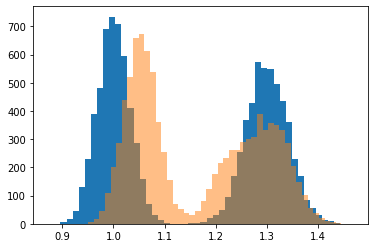

In [5]:
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);

---

Norm $O(\sqrt{D})$

In [6]:
%%time
D = 500
res = run_experiment(
    dim=D,
    s1=1.0, s2=1.3,
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=20,
    attack_norm=2,
    attack_eps=0.1 * np.sqrt(D),
    attack_eps_step=0.01 * np.sqrt(D),
    attack_iters=20,
)

Epoch 1/20
391/391 - 1s - loss: 0.6803 - accuracy: 0.5553 - val_loss: 0.6754 - val_accuracy: 0.5162
Epoch 2/20
391/391 - 1s - loss: 0.4726 - accuracy: 0.7722 - val_loss: 0.4091 - val_accuracy: 0.8156
Epoch 3/20
391/391 - 1s - loss: 0.1512 - accuracy: 0.9428 - val_loss: 0.4123 - val_accuracy: 0.8426
Epoch 4/20
391/391 - 1s - loss: 0.0736 - accuracy: 0.9727 - val_loss: 0.4063 - val_accuracy: 0.8515
Epoch 5/20
391/391 - 1s - loss: 0.0528 - accuracy: 0.9812 - val_loss: 0.3165 - val_accuracy: 0.8860
Epoch 6/20
391/391 - 1s - loss: 0.0406 - accuracy: 0.9849 - val_loss: 0.3078 - val_accuracy: 0.8964
Epoch 7/20
391/391 - 1s - loss: 0.0381 - accuracy: 0.9864 - val_loss: 0.2787 - val_accuracy: 0.9026
Epoch 8/20
391/391 - 1s - loss: 0.0302 - accuracy: 0.9891 - val_loss: 0.2850 - val_accuracy: 0.9078
Epoch 9/20
391/391 - 1s - loss: 0.0263 - accuracy: 0.9903 - val_loss: 0.3295 - val_accuracy: 0.8956
Epoch 10/20
391/391 - 1s - loss: 0.0261 - accuracy: 0.9904 - val_loss: 0.3260 - val_accuracy: 0.8949

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 0.9975600242614746
Nat test  acc : 0.9365000128746033
Adv train acc : 0.3425000011920929
Adv test  acc : 0.13699999451637268
Wall time: 24.9 s


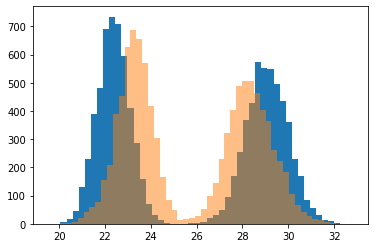

In [7]:
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);

---

Norm $O(1)$ + BatchNorm

In [8]:
%%time
D = 500
res = run_experiment(
    dim=D,
    s1=1.0 / np.sqrt(D), s2=1.3 / np.sqrt(D),
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=10,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
)

Epoch 1/10
391/391 - 1s - loss: 0.0553 - accuracy: 0.9792 - val_loss: 0.2563 - val_accuracy: 0.8756
Epoch 2/10
391/391 - 1s - loss: 0.0214 - accuracy: 0.9921 - val_loss: 0.0478 - val_accuracy: 0.9819
Epoch 3/10
391/391 - 1s - loss: 0.0182 - accuracy: 0.9936 - val_loss: 0.0373 - val_accuracy: 0.9877
Epoch 4/10
391/391 - 1s - loss: 0.0141 - accuracy: 0.9952 - val_loss: 0.0508 - val_accuracy: 0.9833
Epoch 5/10
391/391 - 1s - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.0514 - val_accuracy: 0.9843
Epoch 6/10
391/391 - 1s - loss: 0.0126 - accuracy: 0.9958 - val_loss: 0.0640 - val_accuracy: 0.9816
Epoch 7/10
391/391 - 1s - loss: 0.0106 - accuracy: 0.9964 - val_loss: 0.0467 - val_accuracy: 0.9849
Epoch 8/10
391/391 - 1s - loss: 0.0102 - accuracy: 0.9965 - val_loss: 0.0455 - val_accuracy: 0.9871
Epoch 9/10
391/391 - 1s - loss: 0.0111 - accuracy: 0.9961 - val_loss: 0.0456 - val_accuracy: 0.9858
Epoch 10/10
391/391 - 1s - loss: 0.0107 - accuracy: 0.9966 - val_loss: 0.0407 - val_accuracy: 0.9903

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 0.9991000294685364
Nat test  acc : 0.9902999997138977
Adv train acc : 0.5727999806404114
Adv test  acc : 0.49619999527931213
Wall time: 23.1 s


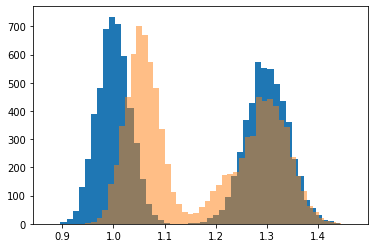

In [9]:
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);

---

Norm $O(\sqrt{D})$ + BatchNorm

In [10]:
%%time
D = 500
res = run_experiment(
    dim=D,
    s1=1.0, s2=1.3,
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=10,
    attack_norm=2,
    attack_eps=0.1 * np.sqrt(D),
    attack_eps_step=0.01 * np.sqrt(D),
    attack_iters=20,
)

Epoch 1/10
391/391 - 1s - loss: 0.0982 - accuracy: 0.9655 - val_loss: 0.0865 - val_accuracy: 0.9697
Epoch 2/10
391/391 - 1s - loss: 0.0470 - accuracy: 0.9823 - val_loss: 0.0683 - val_accuracy: 0.9760
Epoch 3/10
391/391 - 1s - loss: 0.0370 - accuracy: 0.9873 - val_loss: 0.0530 - val_accuracy: 0.9821
Epoch 4/10
391/391 - 1s - loss: 0.0345 - accuracy: 0.9877 - val_loss: 0.0513 - val_accuracy: 0.9818
Epoch 5/10
391/391 - 1s - loss: 0.0291 - accuracy: 0.9901 - val_loss: 0.0618 - val_accuracy: 0.9785
Epoch 6/10
391/391 - 1s - loss: 0.0294 - accuracy: 0.9896 - val_loss: 0.0600 - val_accuracy: 0.9779
Epoch 7/10
391/391 - 1s - loss: 0.0233 - accuracy: 0.9920 - val_loss: 0.0580 - val_accuracy: 0.9811
Epoch 8/10
391/391 - 1s - loss: 0.0200 - accuracy: 0.9931 - val_loss: 0.0554 - val_accuracy: 0.9815
Epoch 9/10
391/391 - 1s - loss: 0.0238 - accuracy: 0.9916 - val_loss: 0.0803 - val_accuracy: 0.9758
Epoch 10/10
391/391 - 1s - loss: 0.0189 - accuracy: 0.9937 - val_loss: 0.0682 - val_accuracy: 0.9777

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 0.9966999888420105
Nat test  acc : 0.9776999950408936
Adv train acc : 0.5630000233650208
Adv test  acc : 0.4571000039577484
Wall time: 22.8 s


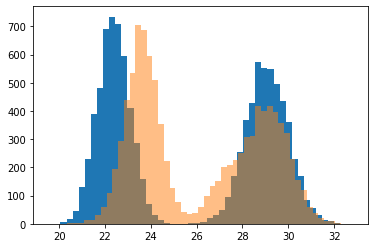

In [11]:
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);

### Summary and conclusions
Overall we get pretty similar behavior in the spherical and Gaussian cases (see sphere-v1.ipynb).

Like in the spherical case,
the vanilla feed-forward NN does worse on norm-$O(\sqrt{D})$ data than norm-$O(1)$ data
(93% test acc vs 99% test acc).
However, this difference can be mitigated with a batchnorm layer.